# Linear Regression

In [1]:
import math

import scipy.stats
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.set(font_scale=1.3, palette='colorblind')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
palette = sns.color_palette('colorblind')

In [3]:
def noisy_line(m, b, sigma, size):
    """
    Generate normally distributed random error ~ N(0, sigma**2)
    https://stackoverflow.com/a/29790403
    """
    xdata = np.linspace(-1.0, 1.0, size)
    errors = scipy.stats.norm.rvs(loc=0, scale=sigma, size=size)
    ydata = m * xdata + b + errors
    return xdata, ydata

theta_1, theta_0 = 2, 3
actual_stdev = 0.25
size = 100
xs, ys = noisy_line(theta_1, theta_0, actual_stdev, size)

In [4]:
# y = 2x + 3
y_f = lambda x: theta_1 * x + theta_0
y = y_f(xs)

In [5]:
def plot_line(x, y=None, ys=None, predictions=None):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    palette = sns.color_palette('colorblind')
    
    if ys is not None:
        ax.plot(x, ys, 'o', label='Noisy data', color=palette[0])
    
    if y is not None:
        ax.plot(x, y, label=f'Actual line', color=palette[1])
    
    if predictions is not None:
        ax.plot(x, predictions, label='Fitted line', color=palette[2])

    ax.legend()
    return f, ax

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12524d198>)

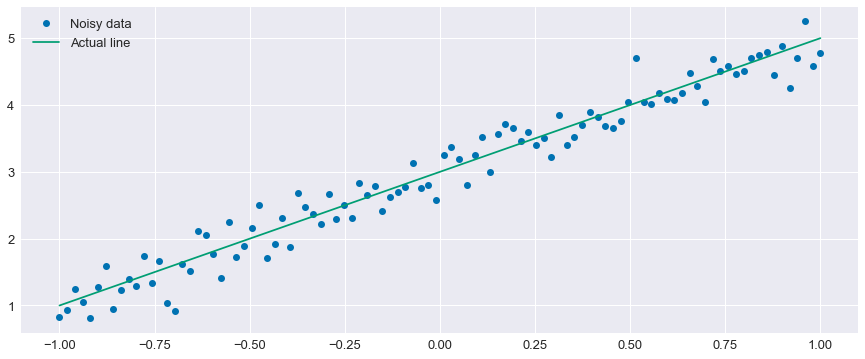

In [6]:
plot_line(xs, y, ys)

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12530e3c8>)

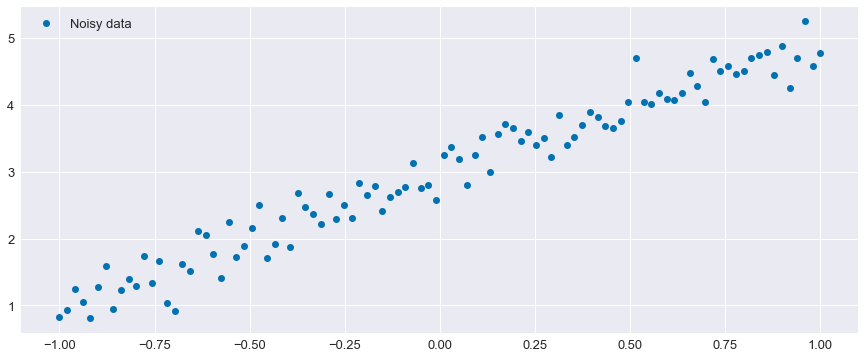

In [7]:
plot_line(xs, ys=ys)

In [8]:
learning_rate = 0.01

x_t = tf.placeholder(tf.float32, [None])
y_t = tf.placeholder(tf.float32, [None])

a = tf.get_variable('slope', dtype=tf.float32, shape=())
b = tf.get_variable('intercept', dtype=tf.float32, shape=())

y_pred = tf.add(tf.multiply(a, x_t), b)

loss = tf.reduce_mean(tf.square(y_pred - y_t))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

In [9]:
init = tf.global_variables_initializer()

x_test = np.linspace(10.0, 100.0, size)
y_test = y_f(x_test)

In [10]:
n_epochs = 200
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run(train_op, feed_dict={x_t: xs, y_t: ys})
        
    mse = float(loss.eval(feed_dict={x_t: xs, y_t: ys}))
    slope, intercept = sess.run([a, b])
    y_hat = y_pred.eval(feed_dict={x_t: xs})
    y_hat_test = y_pred.eval(feed_dict={x_t: x_test})
    mse_test = float(loss.eval(feed_dict={x_t: x_test, y_t: y_test}))


Slope: 1.7919, intercept: 2.8988


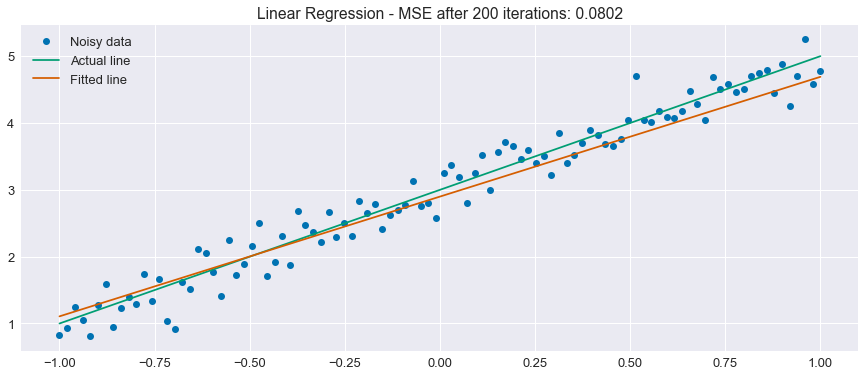

In [11]:
f, ax = plot_line(xs, y, ys, y_hat)
ax.set_title(f'Linear Regression - MSE after {n_epochs} iterations: {round(mse, 4)}')
print()
print(f'Slope: {round(float(slope), 4)}, intercept: {round(float(intercept), 4)}')

With normalization:

In [12]:
scale = lambda x, scaler: scaler.fit_transform(x.reshape((len(x), 1))).flatten()
inverse_scale = lambda x, scaler: scaler.inverse_transform(x.reshape((len(x), 1))).flatten()

In [13]:
def train_linear_regression(x, y, n_epochs):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            sess.run(train_op, feed_dict={x_t: x_n, y_t: y_n})

        return saver.save(sess, "./linreg.ckpt")

In [14]:
save_path = train_linear_regression(xs, ys, n_epochs)

In [15]:
def predict(x, y, save_path):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_hat_n, mse = sess.run([y_pred, loss], feed_dict={x_t: x_n, y_t: y_n})
        
    return inverse_scale(y_hat_n, y_scaler), float(mse)

In [16]:
y_hat, mse = predict(xs, ys, save_path)
y_hat_test, mse_test = predict(x_test, y_test, save_path)

INFO:tensorflow:Restoring parameters from ./linreg.ckpt
INFO:tensorflow:Restoring parameters from ./linreg.ckpt


Text(0.5,1,'Linear Regression - MSE after 200 iterations: 0.0433')

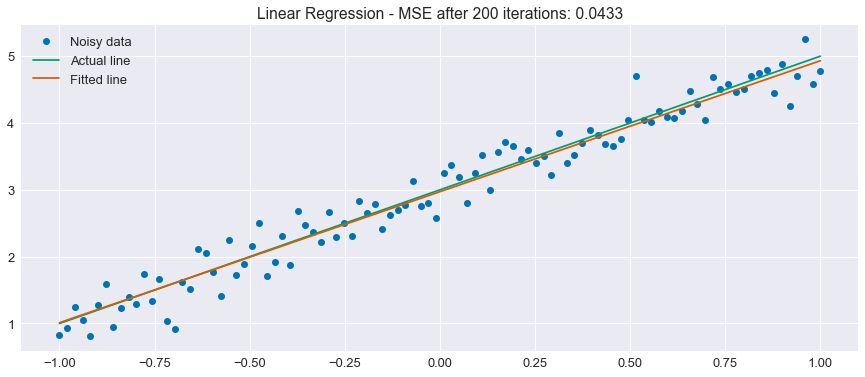

In [17]:
f, ax = plot_line(xs, y, ys, y_hat)
ax.set_title(f'Linear Regression - MSE after {n_epochs} iterations: {round(mse, 4)}')

## Model the error

In [18]:
sigma = tf.get_variable('sigma', dtype=tf.float32, shape=())

y_likelihood = y_pred + tf.random_normal(tf.shape(y_pred), mean=0.0, stddev=sigma, dtype=tf.float32)

log_likelihood = -1 * (
    -0.5 * tf.log(tf.square(sigma)) +
    -0.5 * tf.divide(1, tf.square(sigma)) * loss
)

train_likelihod_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(log_likelihood)

In [19]:
def train_likelihood(x, y, n_epochs):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        for epoch in range(n_epochs):
            sess.run(train_likelihod_op, feed_dict={x_t: x_n, y_t: y_n})

        return saver.save(sess, "./linreg_err.ckpt")

In [20]:
n_epochs_likelihood = 1000

In [21]:
likelihood_save_path = train_likelihood(xs, ys, n_epochs_likelihood)

In [22]:
def predict_likelihood(x, y, save_path):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_hat_n, mse, stdev = sess.run([y_pred, loss, sigma], feed_dict={x_t: x_n, y_t: y_n})

    return inverse_scale(y_hat_n, y_scaler), float(mse), float(stdev)

In [23]:
y_hat_l, mse_l, stdev = predict_likelihood(xs, ys, likelihood_save_path)
print(f'stdev: {stdev}')
y_hat_test_l, mse_test_l, _ = predict_likelihood(x_test, y_test, likelihood_save_path)

INFO:tensorflow:Restoring parameters from ./linreg_err.ckpt
stdev: -0.20734412968158722
INFO:tensorflow:Restoring parameters from ./linreg_err.ckpt


Text(0.5,1,'Linear Regression - MSE after 1000 iterations: 0.043')

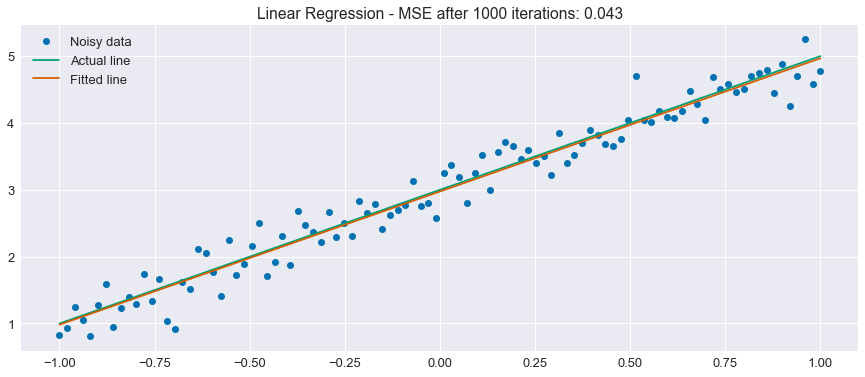

In [24]:
f, ax = plot_line(xs, y, ys=ys, predictions=y_hat_l)
ax.set_title(f'Linear Regression - MSE after {n_epochs_likelihood} iterations: {round(mse_l, 4)}')

## Generate new points

In [25]:
def forecast_likelihood(x, y, save_path):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_hat_n, y_lik_n, mse_lik, stdev, slope_n, intercept_n = sess.run(
            [y_pred, y_likelihood, loss, sigma, a, b], 
            feed_dict={x_t: x_n, y_t: y_n}
        )

    y_hat = inverse_scale(y_hat_n, y_scaler)

    return (
        y_hat, 
        inverse_scale(y_lik_n, y_scaler), 
        float(stdev),
        float(mse_lik)
    )

In [26]:
_, y_lik, stdev, mse_l = forecast_likelihood(x_test, ys, likelihood_save_path)
print(f'stdev: {stdev}')

INFO:tensorflow:Restoring parameters from ./linreg_err.ckpt
stdev: -0.20734412968158722


In [27]:
def plot_new_data(x, y, y_hat):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    palette = sns.color_palette('colorblind')
    
    ax.plot(x, y, 'o', label='Actual', color=palette[0])
    ax.plot(x, y_hat, 'o', label='Draw', color=palette[2])

    ax.legend()
    return f, ax

Text(0.5,1,'Draw from function')

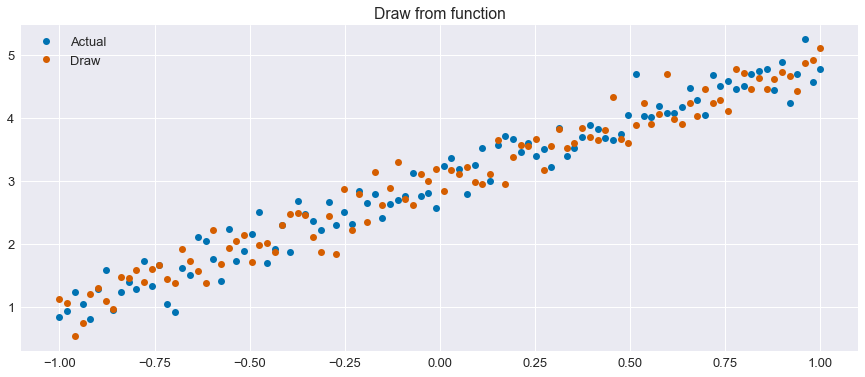

In [28]:
f, ax = plot_new_data(xs, ys, y_lik)
ax.set_title(f'Draw from function')

With error bars at +- 2 * sigma:

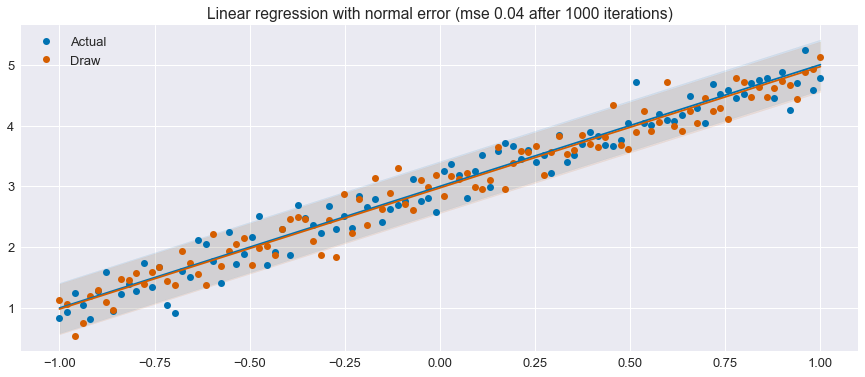

In [29]:
f, ax = plot_new_data(xs, ys, y_lik)

y_err_actual_low = y - 2 * stdev
y_err_actual_high = y + 2 * stdev

y_err_low = y_hat_l - 2 * stdev
y_err_high = y_hat_l + 2 * stdev

ax.plot(xs, y, '-', color=palette[0], alpha=1.0)
ax.fill_between(xs, y_err_actual_low, y_err_actual_high, color=palette[0], alpha=0.1)

ax.plot(xs, y_hat_l, '-', color=palette[2], alpha=1.0)
ax.fill_between(xs, y_err_low, y_err_high, color=palette[2], alpha=0.1)
                 
ax.set_title(
    'Linear regression with normal error '
    f'(mse {round(mse_l, 2)} after {n_epochs_likelihood} iterations)'
)
ax.legend()

## Bayesian Regression

How uncertain is our prediction?

#### Priors

In [30]:
a_values = np.linspace(1, 5, 50)
b_values = np.linspace(1, 5, 50)
sigma_values = np.linspace(0.1, 1, 50)

In [31]:
a_p = tf.placeholder(tf.float32, ())
b_p = tf.placeholder(tf.float32, ())
sigma_p = tf.placeholder(tf.float32, ())

def log_lyk_f(y, mu, s):
    return -tf.log(s * tf.sqrt(2 * tf.constant(math.pi))) - tf.divide(tf.square(y - mu), 2 * tf.square(s))

y_p = tf.add(tf.multiply(a_p, x_t), b_p)

log_lyk = log_lyk_f(y_t, y_p, sigma_p)
log_posterior = tf.reduce_sum(log_lyk)

In [66]:
def compute_posterior(a, b, s):
    with tf.Session() as sess:
        init.run()
        return sess.run(log_posterior, feed_dict={
            x_t: xs,
            y_t: ys,
            a_p: a,
            b_p: b,
            sigma_p: s,
        })
    
print(compute_posterior(5.0, 5.0, 0.1))
print(compute_posterior(5.0, 4.29, 0.34))
print(compute_posterior(2.0, 3.0, 0.25))

-36039.78
-2088.085
-2.2994156


In [60]:
import time

def estimate_parameters(x_vals, y_vals, a_vals, b_vals, sigma_vals):
    output = np.zeros((len(a_vals), len(b_vals), len(sigma_vals)))
    with tf.Session() as sess:
        init.run()
        for i, a_v in enumerate(a_vals):
            if i == 0 or (i + 1) % 10 == 0:
                print(f'{i+1} / {len(a_vals)}')
            for j, b_v in enumerate(b_vals):
                for k, sigma_v in enumerate(sigma_vals):
                    log_post = sess.run(
                        [log_posterior], 
                        feed_dict={x_t: x_vals, y_t: y_vals, a_p: a_v, b_p: b_v, sigma_p: sigma_v}
                    )[0]
                    output[i][j][k] = log_post
    return np.exp(output - np.max(output))

In [33]:
def plot_marginal_distributions(a_values, b_values, sigma_values, output):
    f, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    p_a_marginalized = np.sum(output, axis=(1, 2))
    p_a_marginalized = p_a_marginalized / np.max(p_a_marginalized)
    axes[0].plot(a_values, p_a_marginalized)
    axes[0].set_title('Slope')
    
    p_b_marginalized = np.sum(output, axis=(0, 2))
    p_b_marginalized = p_b_marginalized / np.max(p_b_marginalized)
    axes[1].plot(b_values, p_b_marginalized)
    axes[1].set_title('Intercept')
    
    p_s_marginalized = np.sum(output, axis=(0, 1))
    p_s_marginalized = p_s_marginalized / np.max(p_s_marginalized)
    axes[2].plot(sigma_values, p_s_marginalized)
    axes[2].set_title('Sigma')

#### 10 data points

In [34]:
output = estimate_parameters(xs[:10], ys[:10], a_values, b_values, sigma_values)

1 / 50
10 / 50
20 / 50
30 / 50
40 / 50
50 / 50


In [35]:
am = np.unravel_index(output.argmax(), output.shape)
round(a_values[am[0]], 2), round(b_values[am[1]], 2), round(sigma_values[am[2]], 2)

(2.47, 3.37, 0.21)

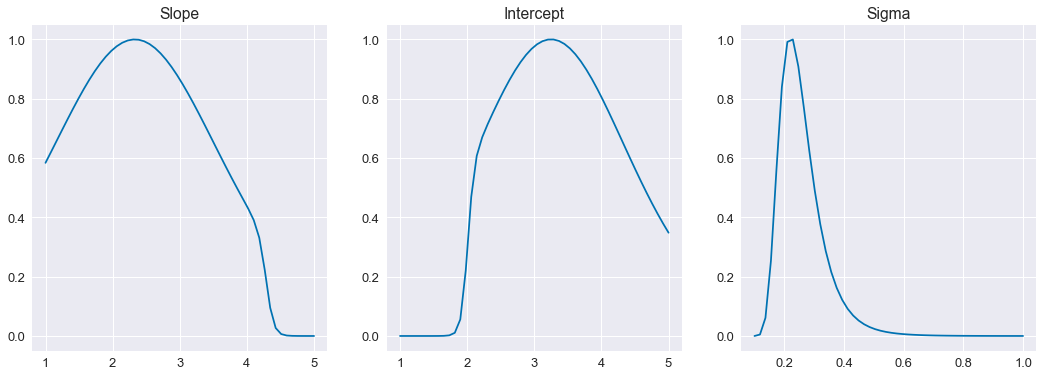

In [36]:
plot_marginal_distributions(a_values, b_values, sigma_values, output)

#### 50 data points

In [37]:
output = estimate_parameters(xs[:30], ys[:30], a_values, b_values, sigma_values)

1 / 50
10 / 50
20 / 50
30 / 50
40 / 50
50 / 50


In [38]:
am = np.unravel_index(output.argmax(), output.shape)
round(a_values[am[0]], 2), round(b_values[am[1]], 2), round(sigma_values[am[2]], 2)

(2.14, 3.04, 0.28)

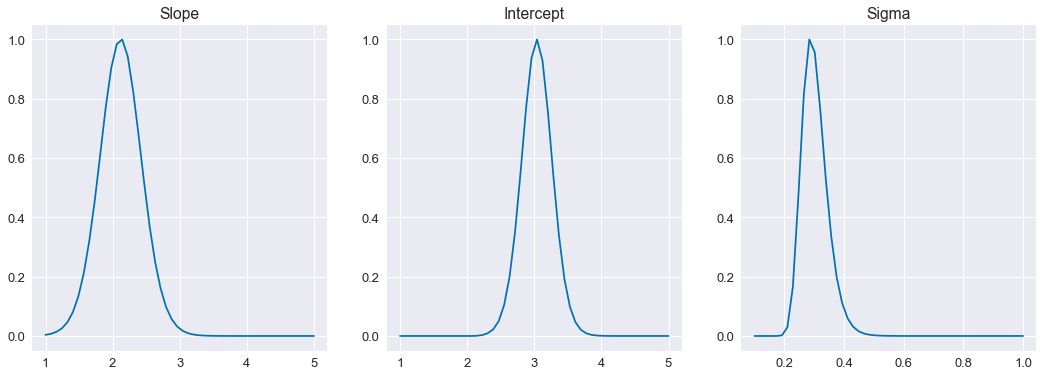

In [39]:
plot_marginal_distributions(a_values, b_values, sigma_values, output)

#### 100 data points

In [40]:
output = estimate_parameters(xs, ys, a_values, b_values, sigma_values)

1 / 50
10 / 50
20 / 50
30 / 50
40 / 50
50 / 50


In [41]:
output[am]

0.00012461027508644352

In [42]:
np.exp(-285.7)

8.35731016107229e-125

In [43]:
am = np.unravel_index(output.argmax(), output.shape)
round(a_values[am[0]], 2), round(b_values[am[1]], 2), round(sigma_values[am[2]], 2)

(1.98, 2.96, 0.25)

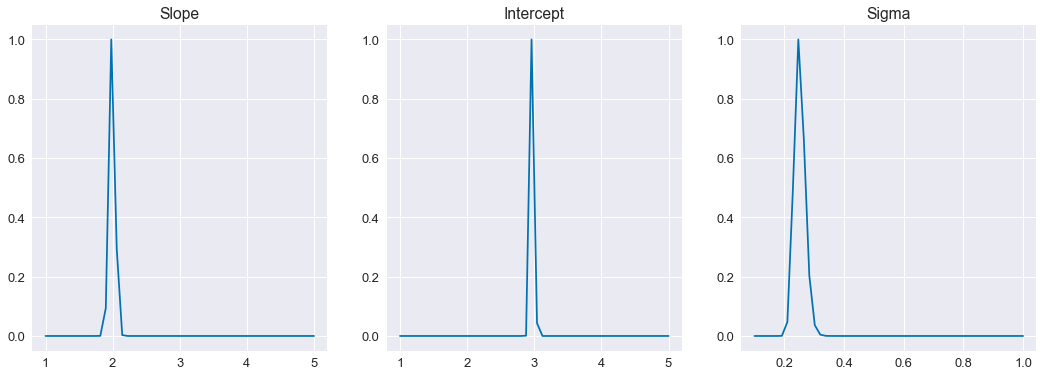

In [44]:
plot_marginal_distributions(a_values, b_values, sigma_values, output)

## Metropolis Hasting

Random walk sampling with acceptance probability `posterior(candidate params) / posterior(current params)`

In [45]:
prior = tfp.distributions.Uniform(low=[1.0, 1.0, 0.1], high=[5.0, 5.0, 1.0])

In [46]:
u1 = tfp.distributions.Uniform(low=0.0, high=1.0)

In [47]:
import time

with tf.Session() as sess:

    log_post_current = sess.run(
        log_posterior, 
        feed_dict={
            x_t: xs, 
            y_t: ys, 
            a_p: 2.4, 
            b_p: 2.8, 
            sigma_p: 0.3,
        }
    )

log_post_current

-53.601345

In [48]:
-53.999245 / - 184

0.29347415760869566

In [49]:
np.exp(0.55)

1.7332530178673953

In [50]:
def metropolis_hasting(x, y, num_samples, prior, initial_parameters, proposal_widths, bounds):
    current_parameters = initial_parameters
    with tf.Session() as sess:
        init.run()
        for i in range(num_samples):            
            proposal_parameters = np.random.multivariate_normal(
                mean=current_parameters,
                cov=np.diag(proposal_widths),
            )
            
            for k, param_bounds in enumerate(bounds):
                min_, max_ = param_bounds[0], param_bounds[1]
                
                if proposal_parameters[k] < min_:
                    proposal_parameters[k] = min_
                elif proposal_parameters[k] > max_:
                    proposal_parameters[k] = max_

            log_post_current = sess.run(
                log_posterior, 
                feed_dict={
                    x_t: x, 
                    y_t: y, 
                    a_p: current_parameters[0], 
                    b_p: current_parameters[1], 
                    sigma_p: current_parameters[2],
                }
            )

            log_post_proposal, u = sess.run(
                [log_posterior, u1.sample()], 
                feed_dict={
                    x_t: x, 
                    y_t: y, 
                    a_p: proposal_parameters[0], 
                    b_p: proposal_parameters[1], 
                    sigma_p: proposal_parameters[2],
                }
            )
            
            p_accept =  log_post_current / log_post_proposal
            
            #print(i)
            #print(f'Current parameters: {current_parameters}')
            #print(f'Proposed parameters: {proposal_parameters}')
            #print(f'post_current: {log_post_current}')
            #print(f'post_proposal: {log_post_proposal}')
            #print(f'p_accept: {p_accept}')
            #print(f'Mean time: {np.mean(time__)}')
            #print()

            if p_accept > u:
                current_parameters = proposal_parameters
                
    return current_parameters    

In [51]:
%%time
initial_parameters = [2.5, 2.5, 0.3]

parameters = metropolis_hasting(
    xs,
    ys, 
    1000, 
    prior, 
    initial_parameters,
    proposal_widths=[0.5, 0.5, 0.1],
    bounds=[[1.0, 5.0], [1.0, 5.0], [0.1, 1.0]],
)

KeyboardInterrupt: 

In [52]:
parameters

NameError: name 'parameters' is not defined